In [1]:
import pandas as pd
from pandas import Series
from pandas import DataFrame
from pandas import concat

from tensorflow.keras.metrics import RootMeanSquaredError as rmse
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from tensorflow.keras.layers import *
from tensorflow.keras.layers import Dense, LSTM, Flatten, TimeDistributed
#from tensorflow.keras.layers.convolutional import Conv1D, MaxPooling1D
from tensorflow.keras.metrics import RootMeanSquaredError as rmse
from tensorflow.keras.optimizers import Adam

import numpy as np
import numpy

import time

import tensorflow as tf

from datetime import datetime
from datetime import datetime as dt

from math import sqrt

import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from matplotlib import pyplot
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
df = pd.read_excel(r'Stock_Price_Training_Data.xlsx')
df_values = df.iloc[:, 1:5].values
df.head()

,Date,Open,High,Low,Close
0,2012-03-01 00:00:00,325.25,332.83,324.97,663.59
1,2012-04-01 00:00:00,331.27,333.87,329.08,666.45
2,2012-05-01 00:00:00,329.83,330.75,326.89,657.21
3,2012-06-01 00:00:00,328.34,328.77,323.68,648.24
4,2012-09-01 00:00:00,322.04,322.29,309.46,620.76


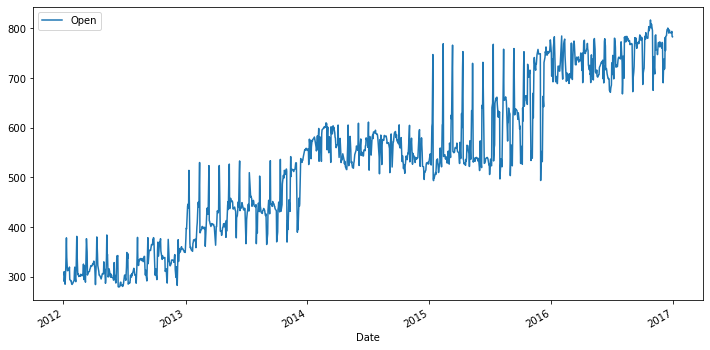

In [3]:
df['Date'] = pd.to_datetime(df['Date']) # convert date column to DateTime
ax = df.plot(x='Date', y='Open', figsize=(12,6))

In [4]:
df.isna().any()

Date     False
Open     False
High     False
Low      False
Close    False
dtype: bool

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1258 non-null   datetime64[ns]
 1   Open    1258 non-null   float64       
 2   High    1258 non-null   float64       
 3   Low     1258 non-null   float64       
 4   Close   1258 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 49.3 KB


In [6]:
df.describe()

,Open,High,Low,Close
count,1258.000000,1258.000000,1258.000000,1258.000000
mean,533.709833,537.880223,529.007409,712.669666
std,151.904442,153.008811,150.552807,164.752591
min,279.120000,281.210000,277.220000,491.200000
25%,404.115000,406.765000,401.765000,576.740000
50%,537.470000,540.750000,532.990000,695.675000
75%,654.922500,662.587500,644.800000,782.105000
max,816.680000,816.680000,805.140000,1216.830000


In [7]:
dataset = df.loc[:,['Open']].values
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [8]:
prevData = 30
monthly_pred = 30

def organiseVectorsOfData(dataset, prevData, monthly_pred):
    X = []
    y = []
    for i in range(prevData,dataset.shape[0]+1): 
        X.append(dataset[i-prevData : i])
        if len(dataset) - i >= monthly_pred:
            y.append(dataset[i:i+monthly_pred])
    
    X = np.array(X)
    y = np.array(y)

    return numpy.array(X), numpy.array(y)


TotalData, nextPart_y = organiseVectorsOfData(dataset, prevData, monthly_pred)
partOfData_X = TotalData[0:(dataset.shape[0]+1 - 2 * prevData),:,:]


TotalData = numpy.reshape(TotalData, (TotalData.shape[0], 1, TotalData.shape[1]))

if prevData == monthly_pred:
    trainX, testX, trainY, testY = train_test_split(partOfData_X, nextPart_y, test_size=0.2, random_state=0, shuffle=False)

    trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))

    testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

    testY = testY.reshape(testY.shape[0], (testY.shape[1]*testY.shape[2]))

    trainY = trainY.reshape(trainY.shape[0], (trainY.shape[1]*trainY.shape[2]))
else:
    if prevData-monthly_pred > 0:
        x_del = 0
        y_del = abs(prevData-monthly_pred)
    else:
        x_del = abs(prevData-monthly_pred)
        y_del = 0
    trainX = partOfData_X[:int((dataset.shape[0]+1 - 2 * prevData)*0.8),:,:]
    trainY = nextPart_y[:int((dataset.shape[0]+1 - 2 * prevData)*0.8),:,:]
    testX = partOfData_X[int((dataset.shape[0]+1 - 2 * prevData)*0.8):(dataset.shape[0]+1 - 2 * prevData - x_del + y_del),:,:]
    testY = nextPart_y[int((dataset.shape[0]+1 - 2 * prevData)*0.8):(dataset.shape[0]+1 - 2 * prevData),:,:]
    
    trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))

    testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

    testY = testY.reshape(testY.shape[0], (testY.shape[1]*testY.shape[2]))

    trainY = trainY.reshape(trainY.shape[0], (trainY.shape[1]*trainY.shape[2]))


In [9]:
model = Sequential()
model.add(LSTM(30, input_shape=(1, prevData), dropout=0.0,recurrent_dropout=0.2))
model.add(Dropout(.2))
model.add(Dense(units=monthly_pred, kernel_initializer='uniform', activation='relu'))
model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate=0.01), loss='mean_squared_error', metrics=[rmse()])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30)                7320      
_________________________________________________________________
dropout (Dropout)            (None, 30)                0         
_________________________________________________________________
dense (Dense)                (None, 30)                930       
Total params: 8,250
Trainable params: 8,250
Non-trainable params: 0
_________________________________________________________________


In [10]:
print(trainX.shape)
print(testX.shape)
print(trainY.shape)
print(testY.shape)

(959, 1, 30)
(240, 1, 30)
(959, 30)
(240, 30)


In [11]:
stime_fit = time.time()
history = model.fit(trainX, trainY, validation_data=(testX, testY),epochs=100, batch_size=1, verbose=2)
ftime_fit = time.time() - stime_fit
print('Fit time is: ' + str(ftime_fit) + ' seconds.')

Epoch 1/100
959/959 - 4s - loss: 0.1311 - root_mean_squared_error: 0.3621 - val_loss: 0.4262 - val_root_mean_squared_error: 0.6528
Epoch 2/100
959/959 - 1s - loss: 0.0655 - root_mean_squared_error: 0.2560 - val_loss: 0.2794 - val_root_mean_squared_error: 0.5286
Epoch 3/100
959/959 - 1s - loss: 0.0467 - root_mean_squared_error: 0.2161 - val_loss: 0.2099 - val_root_mean_squared_error: 0.4581
Epoch 4/100
959/959 - 1s - loss: 0.0410 - root_mean_squared_error: 0.2025 - val_loss: 0.1765 - val_root_mean_squared_error: 0.4202
Epoch 5/100
959/959 - 1s - loss: 0.0373 - root_mean_squared_error: 0.1932 - val_loss: 0.1475 - val_root_mean_squared_error: 0.3841
Epoch 6/100
959/959 - 1s - loss: 0.0312 - root_mean_squared_error: 0.1767 - val_loss: 0.1231 - val_root_mean_squared_error: 0.3509
Epoch 7/100
959/959 - 1s - loss: 0.0275 - root_mean_squared_error: 0.1659 - val_loss: 0.1069 - val_root_mean_squared_error: 0.3269
Epoch 8/100
959/959 - 1s - loss: 0.0251 - root_mean_squared_error: 0.1586 - val_los

Epoch 64/100
959/959 - 1s - loss: 0.0055 - root_mean_squared_error: 0.0740 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0573
Epoch 65/100
959/959 - 1s - loss: 0.0054 - root_mean_squared_error: 0.0733 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0567
Epoch 66/100
959/959 - 1s - loss: 0.0055 - root_mean_squared_error: 0.0745 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0568
Epoch 67/100
959/959 - 1s - loss: 0.0054 - root_mean_squared_error: 0.0735 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0565
Epoch 68/100
959/959 - 1s - loss: 0.0050 - root_mean_squared_error: 0.0708 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0567
Epoch 69/100
959/959 - 1s - loss: 0.0056 - root_mean_squared_error: 0.0748 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0574
Epoch 70/100
959/959 - 1s - loss: 0.0053 - root_mean_squared_error: 0.0730 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0563
Epoch 71/100
959/959 - 1s - loss: 0.0054 - root_mean_squared_error: 0.0732 -

In [12]:
weights = model.get_weights()
print('Final (trained) weights are:')
print(weights)

Final (trained) weights are:
[array([[ 0.13778643,  0.15497209,  0.05040068, ...,  0.03795552,
        -0.05546284,  0.00167405],
       [-0.11565646,  0.08586153, -0.1485044 , ...,  0.03038634,
         0.10716158, -0.1703857 ],
       [-0.0018411 ,  0.08511387, -0.12778005, ...,  0.18865992,
        -0.15764761,  0.1652603 ],
       ...,
       [ 0.07299233,  0.00622576,  0.2349525 , ..., -0.1160375 ,
         0.21118477, -0.14588146],
       [ 0.15330435,  0.04464478, -0.01066682, ...,  0.04555711,
         0.16005841, -0.0287198 ],
       [-0.10416795,  0.23994362,  0.09157489, ...,  0.16890691,
        -0.0165818 , -0.11815432]], dtype=float32), array([[ 0.16990912, -0.14756145,  0.11781441, ...,  0.04497799,
        -0.18069969,  0.05090402],
       [ 0.13024543,  0.0497927 ,  0.27307948, ..., -0.09619292,
         0.07038637, -0.09038004],
       [-0.03555223,  0.07877218, -0.04702687, ...,  0.05570652,
         0.1175978 ,  0.12966312],
       ...,
       [-0.08645306, -0.15566

In [13]:
traintime_predict = time.time()
trainX_pred = model.predict(trainX)
ftraintime_predict = time.time() - traintime_predict
print('Prediction for train time is: ' + str(ftraintime_predict) + ' seconds.')

stime_predict = time.time()
res_pred = model.predict(testX)
ftime_predict = time.time() - stime_predict
print('Prediction for test time is: ' + str(ftime_predict) + ' seconds.')

Prediction for train time is: 0.35622739791870117 seconds.
Prediction for test time is: 0.06307196617126465 seconds.


In [14]:
def deleteParts(arr):
    woParts = []
    for k in range(arr.shape[0]):
        woParts.append(arr[k,0])
    for p in range(arr.shape[1]):
        woParts.append(arr[arr.shape[0]-1, p])
    woParts = np.array(woParts)
    return(woParts)

testY_final = deleteParts(testY)
res_pred_final = deleteParts(res_pred)

from sklearn.metrics import mean_squared_error, mean_absolute_error

print('MSE: ' + str(mean_squared_error(testY_final, res_pred_final)))  # MSE

print('RMSE: ' + str(mean_squared_error(testY_final, res_pred_final, squared=False)))# RMSE

print('MAE: ' + str(mean_absolute_error(testY_final, res_pred_final))) # MAE

MSE: 0.0013628544122665947
RMSE: 0.03691685810394209
MAE: 0.028374698465180388


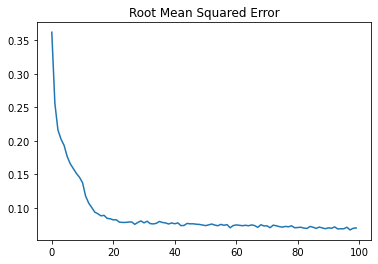

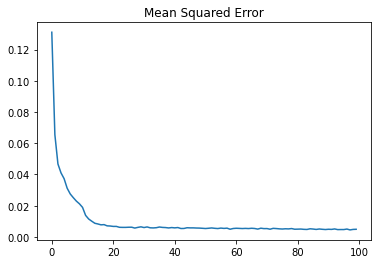

In [15]:
plt.plot(history.history['root_mean_squared_error'])
plt.title('Root Mean Squared Error')
plt.show()
plt.plot(history.history['loss'])
plt.title('Mean Squared Error')
plt.show()

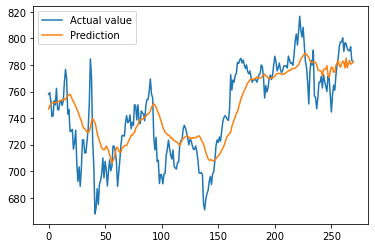

In [16]:
testY_final = np.reshape(testY_final, (-1, 1))
res_pred_final = np.reshape(res_pred_final, (-1, 1))

testY_inv = scaler.inverse_transform(testY_final)
res_pred_inv = scaler.inverse_transform(res_pred_final)

plt.plot(testY_inv)
plt.plot(res_pred_inv)
plt.legend(['Actual value', 'Prediction'])
plt.show()

Fit time is: 0.08836221694946289 seconds.


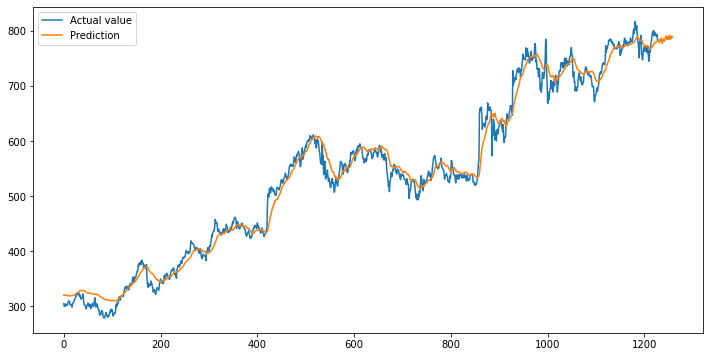

In [17]:
stime_predict = time.time()
res_pred = model.predict(TotalData)
ftime_predict = time.time() - stime_predict
print('Fit time is: ' + str(ftime_predict) + ' seconds.')

res_pred = deleteParts(res_pred)
y_prev = deleteParts(nextPart_y)

res_pred = np.reshape(res_pred, (-1, 1))
y_prev = np.reshape(y_prev, (-1, 1))

res_pred = scaler.inverse_transform(res_pred)
y_prev = scaler.inverse_transform(y_prev)

plt.figure(figsize=(12,6))
plt.plot(y_prev)
plt.plot(res_pred)
plt.legend(['Actual value', 'Prediction'])
plt.show()